# Notebook Imports


In [1]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# Constants

In [121]:
EXAMPLE_FILE = 'D:/COURSES/[FreeCourseSite.com] Udemy - Complete 2022 Data Science & Machine Learning Bootcamp/06. Pre-Process Text Data for a Naive Bayes Classifier to Filter Spam Emails Part 1/spam/SpamData/01_Processing/practice_email.txt'
SPAM_PATH_1 = 'spam/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_PATH_2 = 'spam/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH= 'C:/Users/USER/spam/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'C:/Users/USER/spam/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CATEGORY = 1
NON_SPAM_CATEGORY = 0
VOCAB_SIZE = 2500

WORD_ID_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/word-by-id.csv'
TRAIN_DATA = 'C:/Users/USER/spam/SpamData/01_Processing/training-data.txt'
TEST_DATA_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/test-data.txt'

WHALE_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'C:/Users/USER/spam/SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [3]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')
message = stream.read()
stream.close()
print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys 
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding = 'latin-1')

is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

#  Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(4):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->

# Email body Extraction

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding = 'latin-1')
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [9]:
def df_from_directory(path, classificataion):
    rows = []
    row_names = []
    
    for file_name , email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY':classificataion})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_PATH_1, SPAM_CATEGORY)
spam_emails = spam_emails.append(df_from_directory(SPAM_PATH_2, SPAM_CATEGORY))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH, NON_SPAM_CATEGORY)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, NON_SPAM_CATEGORY))
non_spam_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [13]:
non_spam_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, non_spam_emails])
print('shape of the emails is:', data.shape)

shape of the emails is: (5799, 2)


# Data cleaning for Missing Values

In [15]:
#check if any message bodies are null 
data['MESSAGE'].isnull().values.any()

False

In [16]:
#check is there any empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
#chellange: how would you check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File entries from Dataframe

In [20]:
data = data.drop(['cmds'])

In [21]:
data.shape

(5796, 2)

# Add Document ID's to track Emails in Dataset

In [22]:
document_ids = range(0, len(data.index))
data['DOC_ID']=document_ids

In [23]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [24]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save to file using Pandas

In [25]:
#data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (pie charts)

In [26]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [27]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_non_spam = data.CATEGORY.value_counts()[0]

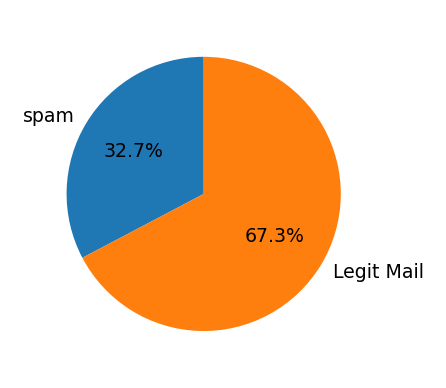

In [28]:
category_names =['spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_non_spam]
plt.figure(figsize =(2,2), dpi = 227)
plt.pie(sizes, labels= category_names, textprops = {'fontsize': 6}, startangle= 90,
       autopct= '%1.1f%%')
plt.show()

### Here i changed the colours by custom colours and adding gap between this using explode. 

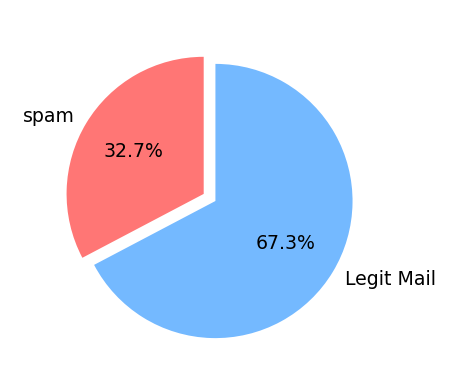

In [29]:
category_names =['spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_non_spam]

custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize =(2,2), dpi = 227)
plt.pie(sizes, labels= category_names, textprops = {'fontsize': 6}, startangle= 90,
       autopct= '%1.1f%%', colors = custom_colours, explode = [0, 0.1])
plt.show()



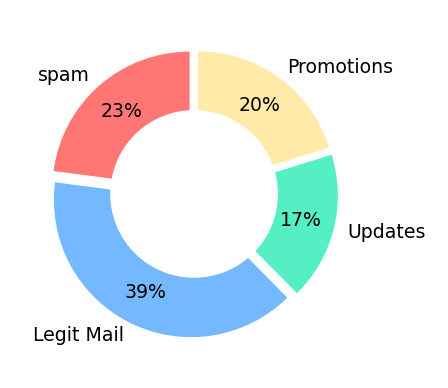

In [30]:
category_names =['spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]  #Here we assumed the values this is not the part of data we imported this is for the purpose to show
offset = [0.05, 0.05, 0.05, 0.05]

custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']

plt.figure(figsize =(2,2), dpi = 227)
plt.pie(sizes, labels= category_names, textprops = {'fontsize': 6}, startangle= 90,
       autopct= '%1.0f%%', colors = custom_colours, pctdistance = 0.75, explode = offset)

# circle plot
centre_circle = plt.Circle((0,0), radius=0.6, color= 'white')
plt.gca().add_artist(centre_circle)
plt.show()

# NLP - Natural Language Processing
### Text Pre Processing

In [31]:
msg = 'All work an no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & stopwords)

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [34]:
nltk.download('shakespeare')

[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenising

In [35]:
msg = 'All work an no play makes jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

# Removing Stop Words

In [36]:
stop_words = set(stopwords.words('english'))

In [37]:
type(stop_words)

set

In [38]:
if 'this' in stop_words: print('found it!')

found it!


In [39]:
if 'hello' not in stop_words: print('Nope! not found it')

Nope! not found it


In [40]:
msg = 'all work and no play makes Jack a dull boy. To be ot not to be.'
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', 'ot', '.']


# Word Stems and Stemming

In [41]:
msg = 'all work and no play makes Jack a dull boy. To be ot not to be.\
nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english') # this stemmer have multiple language stemming feature

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', 'ot', 'be.nobodi', 'expect', 'spanish', 'inquisit', '!']


# Removing Punctuation

In [42]:
msg = 'all work and no play makes Jack a dull boy. To be ot not to be.???\
nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer('english') 

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'ot', 'nobodi', 'expect', 'spanish', 'inquisit']


# Removing HTML Tags

In [43]:
soup = BeautifulSoup(data.at[5, 'MESSAGE'], 'html.parser')
print(soup.prettify())

A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 

 

  GET IN WITH THE FOUNDERS! 

The MAJOR PLAYERS are on This ONE

For ONCE be where the PlayerS are

This is YOUR Private Invitation



EXPERTS ARE CALLING THIS THE FASTEST WAY 

TO HUGE CASH FLOW EVER CONCEIVED

Leverage $1,000 into $50,000 Over and Over Again



THE QUESTION HERE IS:

YOU EITHER WANT TO BE WEALTHY 

OR YOU DON'T!!!

WHICH ONE ARE YOU?

I am tossing you a financial lifeline and for your sake I 

Hope you GRAB onto it and hold on tight For the Ride of youR life!



Testimonials



Hear what average people are doing their first few days:

We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL

 I'm a single mother in FL and I've received 12,000 in the last 4 days. D. S. in FL

I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day! L.L. in KY

I didn't have the money, so I found myself a partner to work this with. We have received $4,

In [44]:
soup.get_text()

'A POWERHOUSE GIFTING PROGRAM You Don\'t Want To Miss! \n\n \n\n  GET IN WITH THE FOUNDERS! \n\nThe MAJOR PLAYERS are on This ONE\n\nFor ONCE be where the PlayerS are\n\nThis is YOUR Private Invitation\n\n\n\nEXPERTS ARE CALLING THIS THE FASTEST WAY \n\nTO HUGE CASH FLOW EVER CONCEIVED\n\nLeverage $1,000 into $50,000 Over and Over Again\n\n\n\nTHE QUESTION HERE IS:\n\nYOU EITHER WANT TO BE WEALTHY \n\nOR YOU DON\'T!!!\n\nWHICH ONE ARE YOU?\n\nI am tossing you a financial lifeline and for your sake I \n\nHope you GRAB onto it and hold on tight For the Ride of youR life!\n\n\n\nTestimonials\n\n\n\nHear what average people are doing their first few days:\n\n\x93We\'ve received 8,000 in 1 day and we are doing that over and over again!\' Q.S. in AL\n\n \x93I\'m a single mother in FL and I\'ve received 12,000 in the last 4 days.\x94 D. S. in FL\n\n\x93I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!\x94 L.L. in KY\n\n\x93I didn\'t have the 

## Function for email Processing

In [45]:
def clean_message(message, stemmer= PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [46]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [47]:
# cleaning HTML tags Function

def clean_message(message, stemmer=PorterStemmer(),
                 stop_words = set(stopwords.words('english'))):
    
    filtered_words = []
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    words = word_tokenize(cleaned_text.lower())
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [48]:
clean_message(data.at[5, 'MESSAGE'])

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one',
 'player',
 'privat',
 'invit',
 'expert',
 'call',
 'fastest',
 'way',
 'huge',
 'cash',
 'flow',
 'ever',
 'conceiv',
 'leverag',
 'question',
 'either',
 'want',
 'wealthi',
 'one',
 'toss',
 'financi',
 'lifelin',
 'sake',
 'hope',
 'grab',
 'onto',
 'hold',
 'tight',
 'ride',
 'life',
 'testimoni',
 'hear',
 'averag',
 'peopl',
 'first',
 'day',
 'receiv',
 'day',
 'al',
 'singl',
 'mother',
 'fl',
 'receiv',
 'last',
 'fl',
 'sure',
 'sent',
 'pledg',
 'got',
 'back',
 'next',
 'day',
 'ky',
 'money',
 'found',
 'partner',
 'work',
 'receiv',
 'last',
 'day',
 'think',
 'made',
 'right',
 'decis',
 'fl',
 'pick',
 'first',
 'day',
 'gave',
 'free',
 'lead',
 'train',
 'ca',
 'announc',
 'close',
 'sale',
 'help',
 'get',
 'fax',
 'blast',
 'immedi',
 'upon',
 'entri',
 'make',
 'money',
 'free',
 'lead',
 'train',
 'wait',
 'call',
 'fax',
 'back',
 'call',
 'best',
 'time',
 'me

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets


In [49]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [50]:
data.iloc[0:5]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [51]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [52]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

192

In [53]:
%%time
nested_list = data.MESSAGE.apply(clean_message)

C:\Users\USER\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 33.3 s


In [54]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

# Using logic to Slice Dataframes

In [55]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [56]:
data[data.CATEGORY == 1].head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [57]:
doc_idx_spam = data[data.CATEGORY == 1].index
doc_idx_non_spam = data[data.CATEGORY == 0].index

In [58]:
doc_idx_non_spam

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a series with an index 

In [59]:
nested_list_non_spam = nested_list.loc[doc_idx_non_spam]

In [60]:
nested_list_spam = nested_list.loc[doc_idx_spam]

In [61]:
flat_list_non_spam = [item for sublist in nested_list_non_spam for item in sublist]
normal_words = pd.Series(flat_list_non_spam)
normal_words.shape[0]

442056

In [62]:
normal_words[0:10]

0        date
1         wed
2         aug
3        chri
4     garrigu
5          ca
6    reproduc
7       error
8      repeat
9        like
dtype: object

In [63]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
normal_words = pd.Series(flat_list_spam)
normal_words.shape[0]

317499

In [64]:
normal_words[:10]

0       save
1       life
2      insur
3      spend
4       life
5       quot
6       save
7          g
8     famili
9    financi
dtype: object

# Creating a word cloud

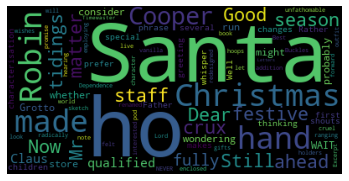

In [65]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation = 'hanning')
plt.axis('off')
plt.show()

In [66]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)


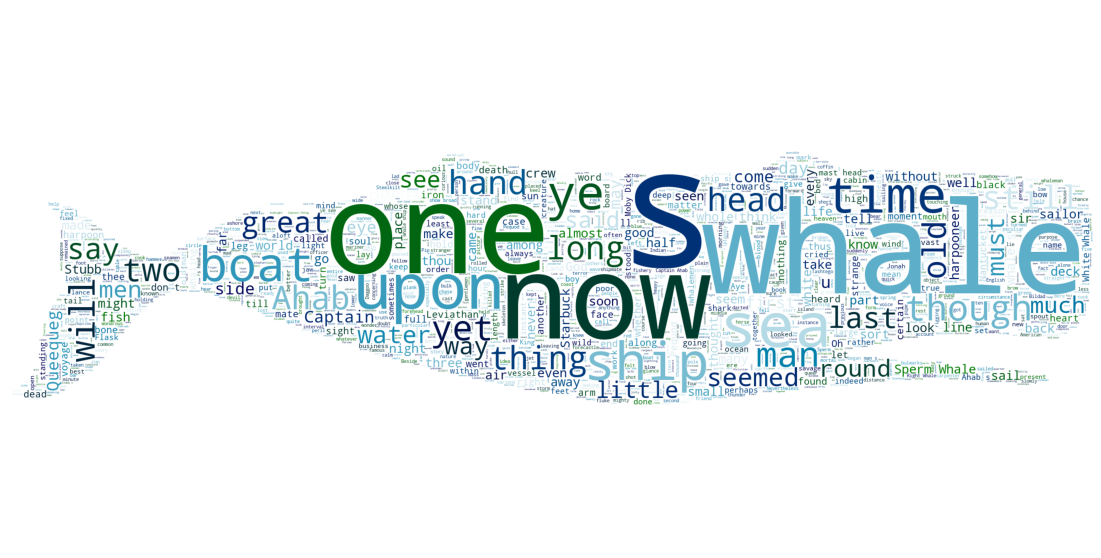

In [67]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object to an array

# word_list = [''.join(word) for word in example_corpus]
# novel_as_string = ' '.join(word_list)
word_cloud = WordCloud(mask= rgb_array, background_color = 'white',max_words = 2000, colormap= 'ocean').generate(novel_as_string)
plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation = 'hanning')
plt.axis('off')
plt.show() 

In [68]:
rgb_array.shape

(1024, 2048, 3)

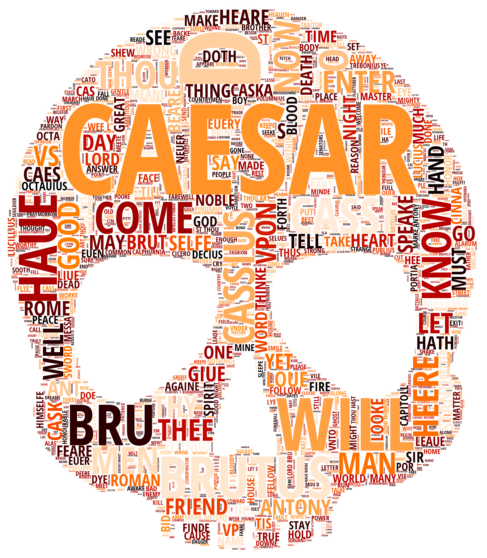

In [69]:
shakespeare_corpus = nltk.corpus.gutenberg.words('shakespeare-caesar.txt')
words_list = [''.join(word) for word in shakespeare_corpus]
novels_as_string = ' '.join(words_list)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask= rgb_array, background_color = 'white',max_words = 2000, colormap= 'gist_heat',font_path = CUSTOM_FONT_FILE)
word_cloud.generate(novels_as_string.upper())
plt.figure(figsize=[20, 10])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show() 

# Generate Vocabulary and Dictionary

In [70]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\USER\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [71]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("No. of unique words:", unique_words.shape[0])
unique_words.head()

No. of unique words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [72]:
frequent_words = unique_words[0:VOCAB_SIZE]
print("most frequent words: ", frequent_words[0:10])

most frequent words:  http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create a Vocabulary Dataframe with a WORD_ID

In [73]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORDS': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORDS
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Saving the vocabulary to the CSV file

In [74]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header =vocab.VOCAB_WORDS.name)


# Checking the words is this the part of vocabulary

In [75]:
any(vocab.VOCAB_WORDS == 'machine') #ineffecient way

False

In [76]:
'app' in set(vocab.VOCAB_WORDS) #efficient way

True

# Exercise: Find the E-mail with the most Number of Words.

In [77]:
# for loop way
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
print('No. of words in the longest E-mail:', max(clean_email_lengths))

No. of words in the longest E-mail: 7671


In [78]:
# list comprehension way
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('No. of words in longest email: ', max(clean_email_lengths))

No. of words in longest email:  7671


In [79]:
print('The position of the email is: ', np.argmax(clean_email_lengths))

The position of the email is:  5775


In [80]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [81]:
data.at[np.argmax(clean_email_lengths),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Creating features & a Sparse Matrix
### Creating a Dataframe with one Word per Column

In [82]:
type(stemmed_nested_list.tolist())

list

In [83]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [84]:
word_columns_df.shape

(5796, 7671)

# Splitting the data into Training and  Testing Dataset

In [85]:
x_train , x_test , y_train , y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state = 42)

In [86]:
print('Number of Training samples:', x_train.shape[0])
print('Fraction of Training set:', x_train.shape[0]/word_columns_df.shape[0])

Number of Training samples: 4057
Fraction of Training set: 0.6999654934437544


In [87]:
x_train.index.name =x_test.index.name = 'DOC_ID'
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [88]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

# Sparse Matrix

In [89]:
word_index = pd.Index(vocab.VOCAB_WORDS)

In [90]:
def make_sparse_matrix(df, indexed_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list =[]
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id  = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item ={'LABELS': category, 'DOC_ID':doc_id, 'OCCURANCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)
            

In [91]:
%%time
sparse_index_df = make_sparse_matrix(x_train, word_index, y_train)

Wall time: 8min 12s


In [92]:
sparse_index_df[:5]

,LABELS,DOC_ID,OCCURANCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1243
2,0,4844,1,502
3,0,4844,1,308
4,0,4844,1,254


In [93]:
sparse_index_df.shape

(429240, 4)

In [94]:
sparse_index_df[-5:]

,LABELS,DOC_ID,OCCURANCE,WORD_ID
429235,1,860,1,47
429236,1,860,1,1431
429237,1,860,1,26
429238,1,860,1,21
429239,1,860,1,126


### Combine Occurances with Pandas groupby() Method

In [116]:
train_group = sparse_index_df.groupby(['DOC_ID', 'WORD_ID', 'LABELS']).sum().reset_index()
train_group.head()

,DOC_ID,WORD_ID,LABELS,OCCURANCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


# Saving the training Data as .txt

In [117]:
np.savetxt(TRAIN_DATA, train_group, fmt = '%d')

In [118]:
train_group.columns

Index(['DOC_ID', 'WORD_ID', 'LABELS', 'OCCURANCE'], dtype='object')

In [119]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [120]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [102]:
x_test.shape

(1739, 7671)

In [107]:
%%time
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)

Wall time: 3min 31s


In [108]:
sparse_test_df.shape

(203366, 4)

In [124]:
test_group = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABELS']).sum().reset_index()
test_group.head()

,DOC_ID,WORD_ID,LABELS,OCCURANCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [125]:
np.savetxt(TEST_DATA_FILE, test_group,fmt='%d')

# Pre-Processing Subtitles and Checking your Understanding

In [126]:
train_doc_ids = set(train_group.DOC_ID)
test_doc_ids = set(test_group.DOC_ID)

In [127]:
len(test_doc_ids)

1724

In [130]:
len(x_test)

1739

In [132]:
set(x_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [135]:
data.MESSAGE[179]

'------=_NextPart_000_00A5_78C83A6B.A1543A16\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nMzU0NHRqVFIwLTM5NUZLa20zNjkyYUN6QjUtNDQ5cGVsMzANCjxodG1sPjxi\n\nb2R5IGxpbms9I0ZGRkYwMCB2bGluaz0jRkZGRjAwIGFsaW5rPSNGRkZGMDAg\n\ndGV4dD0jRkZGRjAwIGJnY29sb3I9IzAwMDAwMD4gPHRhYmxlIGJvcmRlckNv\n\nbG9yPSMwMDAwMDAgd2lkdGg9NjAwIGFsaWduPWNlbnRlciBiZ0NvbG9yPSM2\n\nNjk5MzMgYm9yZGVyPTM+PHRyPjx0ZCBhbGlnbj1taWRkbGU+PGZvbnQgZmFj\n\nZT1BcmlhbCxIZWx2ZXRpY2Esc2Fucy1zZXJpZj48YnI+IDxmb250IGNvbG9y\n\nPXdoaXRlIHNpemU9KzM+PGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5l\n\ndC93ZXRiaXRzL2luZGV4Lmh0bT5XZXRiaXRzPC9hPjwvZm9udD48L2ZvbnQ+\n\nPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1hdGNoLm5ldC93ZXRiaXRzL2luZGV4\n\nLmh0bT4gPC9hPjxwPjxmb250IGZhY2U9QXJpYWwsSGVsdmV0aWNhLHNhbnMt\n\nc2VyaWYgY29sb3I9I2ZmZmYwMCBzaXplPTM+PGI+IEdvbGRlbiBTaG93ZXIg\n\nRXh0cmF2YWdhbnphPC9iPjwvZm9udD48Zm9udCBmYWNlPUFyaWFsLEhlbHZl\n\ndGljYSxzYW5zLXNlcmlmPjxicj4gPGEgaHJlZj1odHRwOi8vd3d3Lnh4eG1h\n\ndGNoLm5ldC93ZXRiaXRzL2luZG

In [136]:
data.loc[179]

MESSAGE      ------=_NextPart_000_00A5_78C83A6B.A1543A16\n\...
CATEGORY                                                     1
FILE_NAME               00180.13a95a2542a0fd01ff24303561cca949
Name: 179, dtype: object

In [143]:
clean_message(data.at[179, 'MESSAGE'])

[]